## Simple Graph

In [1]:
from typing import TypedDict, Literal, Annotated
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_ollama import ChatOllama
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [2]:
class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    total_inr: float

In [3]:
def calc_total(state: PortfolioState) -> PortfolioState:
    state['total_usd'] = state['amount_usd'] * 1.08    # amount * return rate
    return state

In [4]:
def to_inr(state: PortfolioState) -> PortfolioState:
    state['total_inr'] = state['total_usd'] * 87.62
    return state

In [5]:
# creating a state graph
builder = StateGraph(PortfolioState)

# adding nodes (functions)
builder.add_node('calc_total_node', calc_total)
builder.add_node('to_inr_node', to_inr)

# adding edges
builder.add_edge(START, 'calc_total_node')
builder.add_edge('calc_total_node', 'to_inr_node')
builder.add_edge('to_inr_node', END)

# building graph
graph = builder.compile()

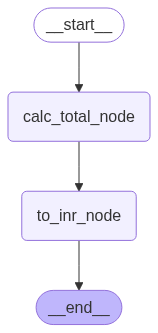

In [6]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
graph.invoke({'amount_usd': 1000})

{'amount_usd': 1000, 'total_usd': 1080.0, 'total_inr': 94629.6}

## Graph with condition

In [8]:
class PortfolioState(TypedDict):
    amount_usd: float
    total_usd: float
    conversion: Literal['INR', 'EUR']
    total: float

In [9]:
def usd_to_inr(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 87.62
    return state

In [10]:
def usd_to_eur(state: PortfolioState) -> PortfolioState:
    state['total'] = state['total_usd'] * 0.86
    return state

In [11]:
def choose_conversion(state: PortfolioState) -> str:
    return state['conversion']

In [12]:
builder = StateGraph(PortfolioState)

builder.add_node('calc_total_node', calc_total)
builder.add_node('to_inr_node', usd_to_inr)
builder.add_node('to_eur_node', usd_to_eur)

builder.add_edge(START, 'calc_total_node')

# conditional edge
builder.add_conditional_edges(
    'calc_total_node',
    choose_conversion,
    {
        'INR': 'to_inr_node',
        'EUR': 'to_eur_node'
    }
)

builder.add_edge(['to_inr_node', 'to_eur_node'], END)

graph = builder.compile()

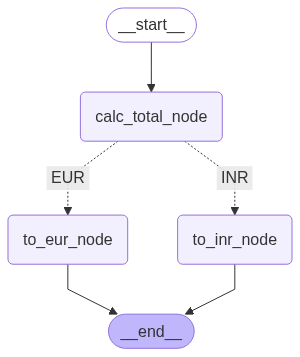

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
graph.invoke({'amount_usd': 1490, 'conversion': 'EUR'})

{'amount_usd': 1490,
 'total_usd': 1609.2,
 'conversion': 'EUR',
 'total': 1383.912}

## Chatbot in langgraph

In [15]:
llm = ChatOllama(model= 'llama3.2')

In [16]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [17]:
def chatbot(state: State) -> State:
    return {'messages': [llm.invoke(state['messages'])]}

In [18]:
builder = StateGraph(State)
builder.add_node('chatbot_node', chatbot)

builder.add_edge(START, 'chatbot_node')
builder.add_edge('chatbot_node', END)

graph = builder.compile()

In [19]:
messages = {'role': 'user', 'content': 'Who walked on the moon for the first time? Print only the name.'}
response = graph.invoke({'messages': [messages]})

response['messages']

[HumanMessage(content='Who walked on the moon for the first time? Print only the name.', additional_kwargs={}, response_metadata={}, id='e2bbd368-bc61-44de-a816-a1dd4e71e5eb'),
 AIMessage(content='Neil Armstrong', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-08-13T11:03:42.5489518Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7700685200, 'load_duration': 4032679200, 'prompt_eval_count': 40, 'prompt_eval_duration': 3398019300, 'eval_count': 3, 'eval_duration': 261284900, 'model_name': 'llama3.2'}, id='run--22b8b34e-858c-4e1e-9fa7-358d159ff5ba-0', usage_metadata={'input_tokens': 40, 'output_tokens': 3, 'total_tokens': 43})]

In [27]:
state: State | None = None

while True:
    message = input('You: ')

    if message.lower() in {'quit', 'exit'}:
        break

    if state is None:
        state = {
            'messages': [{'role': 'user', 'content': message}]
        }

    else:
        state['messages'].append({'role': 'user', 'content': message})

    state = graph.invoke(state)
    print('You:', state['messages'][-2].content)
    print('Bot:', state['messages'][-1].content)

You: Who walked on the moon for the first time? Print only the name.
Bot: Neil Armstrong
You: In which year
Bot: 1969
You: who was the second
Bot: Edwin "Buzz" Aldrin
You: In which rocket does Neil went there?
Bot: Apollo 11
You: who built apollo 11
Bot: NASA (National Aeronautics and Space Administration)


## Chatbot with Tool

In [20]:
# this could be any API or tool

@tool
def get_stock_price(symbol: str) -> float:
    # docstring is necessary, or we can give description in @tool
    """Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    """
    return {
        'MSFT': 200.3,
        'AAPL': 100.4,
        'AMZN': 150.2,
        'RIL': 87.6
    }.get(symbol, 0.0)

In [21]:
tools = [get_stock_price]
llm_with_tools = llm.bind_tools(tools)

In [22]:
def chatbot(state: State) -> dict:
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

In [23]:
builder = StateGraph(State)
builder.add_node(chatbot)
builder.add_node('tools', ToolNode(tools))

builder.add_edge(START, 'chatbot')
builder.add_conditional_edges('chatbot', tools_condition)
builder.add_edge('tools', 'chatbot')

graph = builder.compile()

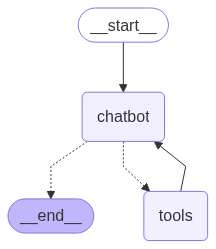

In [24]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
state = graph.invoke({'messages': [{'role': 'user', 'content': 'What is the price of the AMZN stock right now?'}]})
state['messages'][-1].content

'The current price of the AMZN stock is $150.20 per share. Please note that stock prices can fluctuate rapidly and may change since the last update. For the most up-to-date pricing, I recommend checking a reliable financial website or service, such as Yahoo Finance or Google Finance, for the latest information.'

In [26]:
state = graph.invoke({'messages': [{'role': 'user', 'content': 'Who invented the theory of relativity? Give person name only'}]})
state['messages'][-1].content

'Albert Einstein'

In [27]:
state = graph.invoke({'messages': [{'role': 'user', 'content': 'I want to buy 20 AMZN stocks using current price. Then I want to purchase 15 MSFT. What will be the total cost?'}]})
print(state['messages'][-1].content)

Based on the current stock prices, 

20 AMZN stocks at $150.2 per share would cost 20 x $150.2 = $3004.00
15 MSFT stocks at $200.3 per share would cost 15 x $200.3 = $3004.55

The total cost for both purchases is $3004.00 + $3004.55 = $6008.55


## Memory

In [28]:
from langgraph.checkpoint.memory import MemorySaver

In [29]:
memory = MemorySaver()

In [30]:
memory_graph = builder.compile(checkpointer= memory)

In [31]:
config = {
    'configurable': {'thread_id': '1'}
}

In [32]:
msg = 'I want to buy 20 AMZN stocks using current price. Then I want to purchase 15 MSFT. What will be the total cost'

state = memory_graph.invoke(
    input= {'messages': [{'role': 'user', 'content': msg}]}, 
    config= config
)
response = state['messages'][-1].content
print(response)

Based on the current prices, the total cost for buying 20 AMZN stocks and 15 MSFT would be:

20 x $150.2 = $3004
15 x $200.3 = $3014.5

The total cost would be: $3004 + $3014.5 = $6018.5


In [33]:
msg = 'Using the current price tell me the total price of 10 RIL stocks and add it to previous total cost'

state = memory_graph.invoke(
    input= {'messages': [{'role': 'user', 'content': msg}]}, 
    config= config
)
response = state['messages'][-1].content
print(response)

The current price of 1 stock of RIL is $87.6.

To find the total price of 10 stocks:
10 x $87.6 = $876

Adding this to the previous total cost:
$6018.5 + $876 = $6894.5


## Human in the loop (HITL)

In [34]:
from langgraph.types import interrupt, Command

In [35]:
@tool
def buy_stocks(symbol: str, quantity: int, total_price: float) -> str:
    '''Buy stocks given the stock symbol and quantity'''
    decision = interrupt(f"Approve buying {quantity} {symbol} stocks for ${total_price:.2f}?")

    if decision == "yes":
        return f"You bought {quantity} shares of {symbol} for a total price of {total_price}"
    else:
        return "Buying declined."

In [36]:
tools = [get_stock_price, buy_stocks]

llm_with_tools = llm.bind_tools(tools)

In [37]:
def chatbot_node(state: State):
    msg = llm_with_tools.invoke(state["messages"])
    return {"messages": [msg]}

In [40]:
memory = MemorySaver()
builder = StateGraph(State)
builder.add_node("chatbot", chatbot_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "chatbot")
builder.add_conditional_edges("chatbot", tools_condition)
builder.add_edge("tools", "chatbot")
builder.add_edge("chatbot", END)
graph = builder.compile(checkpointer= memory)

In [41]:
config = {"configurable": {"thread_id": "buy_thread"}}

In [42]:
state = graph.invoke({"messages":[{"role":"user","content":"What is the current price of 10 MSFT stocks?"}]}, config=config)
print(state["messages"][-1].content)

The current price of 10 MSFT stocks is approximately $200.30 per share. Please note that stock prices can fluctuate rapidly and may have changed since the last update. For the most up-to-date information, I recommend checking a reliable financial website or platform.


In [43]:
state = graph.invoke({"messages":[{"role":"user","content":"Buy 10 MSFT stocks at current price."}]}, config=config)
print(state.get("__interrupt__"))

[Interrupt(value='Approve buying 10 MSFT stocks for $200.30?', id='04e990031252ec8d139b54a31420a554')]


In [44]:
decision = input("Approve (yes/no): ")
state = graph.invoke(Command(resume=decision), config=config)
print(state["messages"][-1].content)

Congratulations! You have successfully purchased 10 shares of Microsoft (MSFT) stock at the current market price of $200.30 per share. Your total investment is $2,003.

Please note that this is a simulated transaction and not actual buying or selling activity. If you'd like to simulate further trades or transactions, feel free to let me know!
